# Demand Prediction

## Importing Libreries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy import sort

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import d2_absolute_error_score

In [4]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor

## Importing Data

In [5]:
dataframe = pd.read_csv(r'DemandPrediction.csv')

In [6]:
df = dataframe.copy()

## Preprocessing Data

In [7]:
new_header = ['ID', 'Product', 'Date','Price', 'Area','Type']

In [8]:
df.columns = new_header 

In [9]:
df.columns

Index(['ID', 'Product', 'Date', 'Price', 'Area', 'Type'], dtype='object')

In [10]:
df.isnull().sum()

ID         0
Product    0
Date       0
Price      0
Area       0
Type       0
dtype: int64

In [11]:
df.nunique()

ID           17031
Product    3384599
Date            29
Price       200322
Area             3
Type             9
dtype: int64

In [12]:
df.dtypes

ID          int64
Product     int64
Date       object
Price       int64
Area       object
Type       object
dtype: object

In [13]:
df['Type'] = df['Type'].str.replace("/", " ")
df['Type'] = df['Type'].astype('category')
df['Area'] = df['Area'].astype('category')

df['ID'] = df['ID'].astype('str')

In [14]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayofWeek'] = df['Date'].dt.dayofweek
df['DayofMonth'] = df['Date'].dt.day
df['DayofYear'] = df['Date'].dt.isocalendar().week

In [15]:
print(df.shape)
df.describe()

(3384599, 12)


,Product,Price,Year,Month,Day,DayofWeek,DayofMonth,DayofYear
count,3.384599e+06,3.384599e+06,3384599.0,3.384599e+06,3.384599e+06,3.384599e+06,3.384599e+06,3384599.0
mean,2.829757e+08,2.151955e+05,2023.0,2.037493e+00,1.547278e+01,2.852789e+00,1.547278e+01,7.095684
std,1.663490e+06,2.976691e+05,0.0,1.899660e-01,5.844054e+00,1.921354e+00,5.844054e+00,0.896772
min,2.799745e+08,0.000000e+00,2023.0,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,6.0
25%,2.816458e+08,1.090000e+05,2023.0,2.000000e+00,1.100000e+01,1.000000e+00,1.100000e+01,6.0
50%,2.828703e+08,1.645000e+05,2023.0,2.000000e+00,1.500000e+01,3.000000e+00,1.500000e+01,7.0
75%,2.841401e+08,2.600000e+05,2023.0,2.000000e+00,2.000000e+01,4.000000e+00,2.000000e+01,8.0
max,2.882566e+08,1.740920e+08,2023.0,3.000000e+00,2.800000e+01,6.000000e+00,2.800000e+01,10.0


### Removing outliers

In [16]:
# remove outliers
df = df[np.abs(df.Price - df.Price.mean()) <= (3 * df.Price.std())]

In [17]:
df.columns

Index(['ID', 'Product', 'Date', 'Price', 'Area', 'Type', 'Year', 'Month',
       'Day', 'DayofWeek', 'DayofMonth', 'DayofYear'],
      dtype='object')

### Encoding Date

In [18]:
lb_enc = LabelEncoder()

In [19]:
df_enc = df.copy()

In [20]:
df_enc.set_index('ID', inplace = True)
df_enc.drop(columns = 'Date',inplace = True)

In [21]:
l_enc = df_enc.columns.to_list()
l_enc

['Product',
 'Price',
 'Area',
 'Type',
 'Year',
 'Month',
 'Day',
 'DayofWeek',
 'DayofMonth',
 'DayofYear']

In [22]:
for i in l_enc:
    if i in ['Product','Price']:
        continue
    else:    
        df_enc[f'{i}Enc'] = lb_enc.fit_transform(df_enc[i])
        df_enc.drop(i,axis = 1, inplace =True)

In [23]:
df_enc.describe()

,Product,Price,AreaEnc,TypeEnc,YearEnc,MonthEnc,DayEnc,DayofWeekEnc,DayofMonthEnc,DayofYearEnc
count,3.365856e+06,3.365856e+06,3.365856e+06,3.365856e+06,3365856.0,3.365856e+06,3.365856e+06,3.365856e+06,3.365856e+06,3.365856e+06
mean,2.829755e+08,2.065773e+05,4.936495e-01,5.297443e+00,0.0,3.746209e-02,1.447337e+01,2.851887e+00,1.447337e+01,1.095775e+00
std,1.663487e+06,1.476237e+05,6.573699e-01,2.232845e+00,0.0,1.898913e-01,5.843916e+00,1.922118e+00,5.843916e+00,8.967713e-01
min,2.799745e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.816463e+08,1.087800e+05,0.000000e+00,3.000000e+00,0.0,0.000000e+00,1.000000e+01,1.000000e+00,1.000000e+01,0.000000e+00
50%,2.828696e+08,1.639000e+05,0.000000e+00,6.000000e+00,0.0,0.000000e+00,1.400000e+01,3.000000e+00,1.400000e+01,1.000000e+00
75%,2.841403e+08,2.578000e+05,1.000000e+00,6.000000e+00,0.0,0.000000e+00,1.900000e+01,4.000000e+00,1.900000e+01,2.000000e+00
max,2.882566e+08,1.108130e+06,2.000000e+00,8.000000e+00,0.0,1.000000e+00,2.700000e+01,6.000000e+00,2.700000e+01,4.000000e+00


### Normalizing Date

In [24]:
df_norm = df_enc.copy()

In [25]:
scaler = MinMaxScaler()

In [26]:
df_norm[['ProductNorm','PriceNorm', 'AreaNorm', 'TypeNorm', 'YearNorm', 'MonthNorm', 'DayNorm', 'DayofWeekNorm', 'DayofMonthNorm', 'DayofYearNorm']] = scaler.fit_transform(df_norm[['Product','Price', 'AreaEnc', 'TypeEnc', 'YearEnc', 'MonthEnc','DayEnc', 'DayofWeekEnc', 'DayofMonthEnc', 'DayofYearEnc']])

<Axes: >

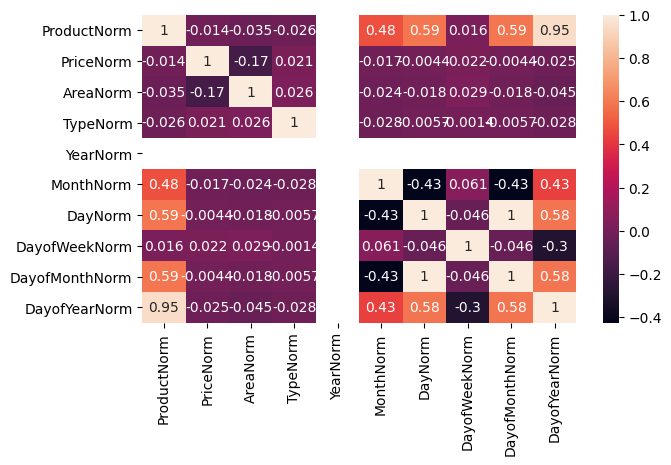

In [27]:
df_corr = df_norm[['ProductNorm','PriceNorm', 'AreaNorm', 'TypeNorm', 'YearNorm', 'MonthNorm', 'DayNorm', 'DayofWeekNorm', 'DayofMonthNorm', 'DayofYearNorm']].corr()
plt.figure(figsize=(7,4))
sns.heatmap(df_corr, annot=True)

In [28]:
#sns.pairplot(df_norm, size=2.5)

## Preparing Models

In [29]:
data = df_norm.copy()

In [30]:
X = data.drop(['Product', 'Price', 'AreaEnc', 'TypeEnc', 'YearEnc', 'MonthEnc','DayEnc', 'DayofWeekEnc', 'DayofMonthEnc', 'DayofYearEnc','YearNorm','ProductNorm'], axis=1)
y = data['ProductNorm']

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost

In [32]:
# Train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
# Evaluate model on testing set
y_pred_xgb = model_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_xgb)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.006718049259184623


In [34]:
mean_squared_error_xgb = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", mean_squared_error_xgb)

Mean Squared Error: 6.868385542877443e-05


In [35]:
y_pred_xgb

array([0.23976417, 0.18538097, 0.542526  , ..., 0.34131172, 0.44602373,
       0.47304723], dtype=float32)

### Linear Regression

In [36]:
###Linear Regression Model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [37]:
CoefficientModel = lin_reg_model.coef_

In [38]:
print('Coefficient of model :', CoefficientModel)

Coefficient of model : [ 7.76520483e-03  2.09599702e-03  2.63962736e-03 -4.91558013e+08
  3.55467170e+09  1.05333860e+08 -4.02867407e+09  4.91558014e+08]


In [39]:
InterceptModel = lin_reg_model.intercept_

In [40]:
print('Intercept of model :',InterceptModel)

Intercept of model : 87778216.68659839


In [41]:
# Root Mean Squared Error on training dataset
predict_train_lin = lin_reg_model.predict(X_train)
rmse_train_lin = mean_squared_error(y_train,predict_train_lin)**(0.5)
print('RMSE on train dataset : ', rmse_train_lin)

RMSE on train dataset :  0.009081716689789108


In [42]:
y_pred_lin = lin_reg_model.predict(X_test)
mean_squared_error_lin = mean_squared_error(y_test, y_pred_lin)
print("Mean Squared Error:", mean_squared_error_lin)

Mean Squared Error: 8.237664447476771e-05


### Decision Tree Regressor

In [43]:
dec_reg_model = DecisionTreeRegressor(random_state=1)
dec_reg_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [44]:
y_pred_dec = dec_reg_model.predict(X_test)
mean_squared_error_dec = mean_squared_error(y_test, y_pred_dec)**(0.5)
print("Mean Squared Error is ", mean_squared_error_dec)

Mean Squared Error is  0.00908696986481296


### Random Forest Regressor

In [45]:
ran_reg_model = RandomForestRegressor(random_state=1)
ran_reg_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [46]:
y_pred_ran = ran_reg_model.predict(X_test)
mean_squared_error_ran = mean_squared_error(y_test, y_pred_ran)**(0.5)
print("Root Mean Squared Error is ", mean_squared_error_ran)

Root Mean Squared Error is  0.008664224328943577


## Evaluating Models 

In [47]:
dict_errors = ({'mean_squared_error_ran':mean_squared_error_ran,'mean_squared_error_dec':mean_squared_error_dec,'mean_squared_error_lin': mean_squared_error_lin,'mean_squared_error_xgb':mean_squared_error_xgb})
min_error = min(dict_errors, key=dict_errors.get)
print("Minimum error is:", dict_errors[min_error], "for", min_error)

Minimum error is: 6.868385542877443e-05 for mean_squared_error_xgb


In [48]:
print(y_pred_xgb)

[0.23976417 0.18538097 0.542526   ... 0.34131172 0.44602373 0.47304723]


## Feature Importances

### Manually Plot Feature Importance

In [49]:
model_xgb.feature_importances_

array([2.7125934e-06, 5.2861792e-06, 2.0767884e-05, 1.7860103e-02,
       3.7631273e-02, 4.5647610e-07, 0.0000000e+00, 9.4447941e-01],
      dtype=float32)

In [50]:
Features = X.columns.to_list()
Features

['PriceNorm',
 'AreaNorm',
 'TypeNorm',
 'MonthNorm',
 'DayNorm',
 'DayofWeekNorm',
 'DayofMonthNorm',
 'DayofYearNorm']

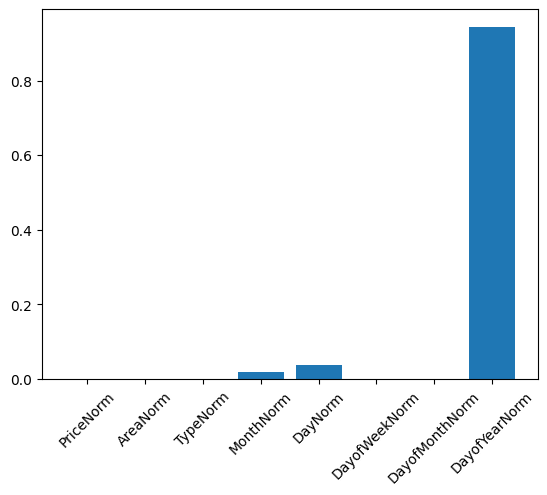

In [51]:
# plot
plt.bar(Features, model_xgb.feature_importances_)
plt.xticks(rotation=45)
plt.show()

### Using theBuilt-in XGBoost Feature Importance Plot

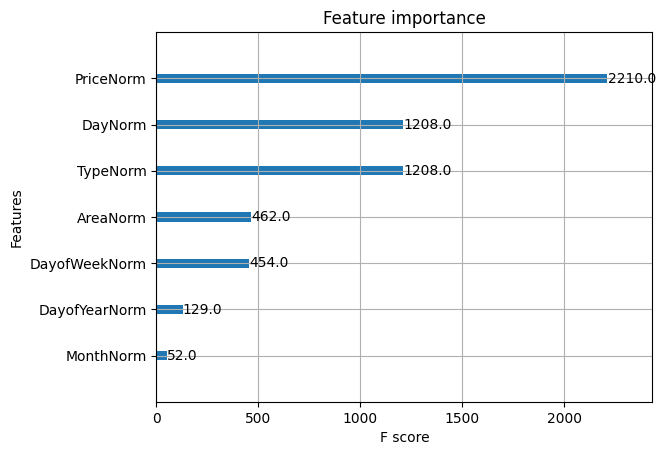

In [52]:

# plot feature importance
plot_importance(model_xgb)
plt.show()

### Feature Importance Score Calculation

In [53]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# fit model on all training data
# Train XGBoost model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
y_pred_xgbr = model_xgb.predict(X_test)
y_pred_xgbr

array([0.23976417, 0.18538097, 0.542526  , ..., 0.34131172, 0.44602373,
       0.47304723], dtype=float32)

In [56]:
predictions = [round(value) for value in y_pred_xgbr]

In [57]:
# Fit model using each importance as a threshold
thresholds = sort(model_xgb.feature_importances_)

In [58]:
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	predictions = selection_model.predict(select_X_test)
	absolute_error_score = d2_absolute_error_score(y_test, y_pred_xgbr)
	print("Thresh=%.3f, n=%d, absolute_error_score: %.2f%%" % (thresh, select_X_train.shape[1], absolute_error_score))

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=8, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=7, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=6, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=5, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=4, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.018, n=3, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.038, n=2, absolute_error_score: 0.96%
Thresh=0.944, n=1, absolute_error_score: 0.96%


c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Rebuild the Model

In [59]:
data = df_norm.copy()

In [60]:
X = data.drop(['Product', 'Price', 'AreaEnc', 'TypeEnc', 'YearEnc', 'MonthEnc','DayEnc', 'DayofWeekEnc', 'DayofMonthEnc', 'DayofYearEnc','YearNorm','ProductNorm','MonthNorm', 'DayofMonthNorm','DayofYearNorm'], axis=1)
y = data['ProductNorm']

In [61]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [63]:
# Evaluate model on testing set
y_pred_xgb = model_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_xgb)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.008216882164888193


In [64]:
mean_squared_error_xgb = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", mean_squared_error_xgb)

Mean Squared Error: 0.0009163894912767327


In [65]:
y_pred_xgb

array([0.24020019, 0.18518354, 0.54244536, ..., 0.34130037, 0.44588032,
       0.4724641 ], dtype=float32)

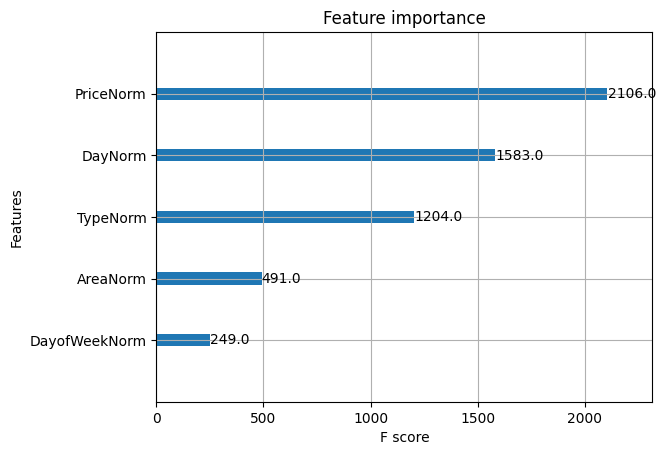

In [66]:
# plot feature importance
plot_importance(model_xgb)
plt.show()

## Test Dataset

In [67]:
df_test = pd.DataFrame(data = y_test)

In [68]:
df_test['Target'] = y_pred_xgb

In [69]:
y = y_pred_xgb.reshape(-1, 1)

In [70]:
df_test['TargetReal'] = scaler.inverse_transform(np.tile(y, (1, 10)))[:, 1]

In [71]:
df_test.head()

,ProductNorm,Target,TargetReal
ID,,,
95909,0.231734,0.240200,266173.03125
273186,0.175857,0.185184,205207.43750
60570,0.534902,0.542445,601100.00000
42981,0.507401,0.509697,564811.06250
270554,0.434085,0.438754,486196.18750
